# Quantum Support Vector Machine

SVM but uses quantum kernels.

## Part I - Regression

### Generic Imports

In [3]:
import warnings
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler #StandardScaler is sensitive to outlier

### Verify File Content

In [4]:
df = pd.read_csv("qml_training-validation-data.csv", index_col = 0)
df.head(6)

,el_neg,B/GPa,Volume/A^3,SFE/mJm^-3
Element,,,,
Be,1.57,130.0,8.09,23.48
Sc,1.36,57.0,25.00,16.16
Ti,1.54,110.0,17.60,24.44
Co,1.88,180.0,11.00,37.64
Zn,1.65,70.0,15.20,20.98
Y,1.22,41.0,33.00,8.52


### Qiskit Imports

In [5]:
from IPython.display import clear_output

from qiskit_aer import Aer
from qiskit.circuit.library import PauliFeatureMap, RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.algorithms import VQR
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit_machine_learning.algorithms import QSVR,QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel

### Data Processing

In [6]:
def prepare_dataset(y_scaler,X,y, test_ratio):
    X_scaler = MinMaxScaler()
    y_scaled = y_scaler.fit_transform(y.reshape(-1,1))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=test_ratio, shuffle=True)
    element_test = X_test[:,0]
    X=X[:,1:]
    max_arr=np.max(X,axis=0)
    X=X/max_arr
    sample_train=X_train[:,1:]/max_arr
    sample_test=X_test[:,1:]/max_arr

    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    X_train = minmax_scale.transform(sample_train)
    X_test = minmax_scale.transform(sample_test)
    
    return X_train, y_train, X_test, y_test, element_test

### Feature Map

In [23]:
def config_feature_map(feature_dimension, reps, entanglement): # assume ZZFeatureMap
    return ZZFeatureMap(feature_dimension=feature_dimension, reps=reps, entanglement=entanglement, insert_barriers=True)

### Kernel

In [17]:
def reconfig_quantum_kernel(feature_map, C, epsilon):
    kernel = FidelityQuantumKernel(feature_map=feature_map)
    qsvr = QSVR(C=C, epsilon=epsilon, quantum_kernel=kernel)
    return qsvr

### Training

In [18]:
def train(qsvr,X_train, y_train, X_test):
    qsvr.fit(X_train, y_train)
    y_hat = qsvr.predict(X_test)
    return y_hat

### Graphing

In [19]:
def graph(y_scaler, y_hat, y_test, message):
    y_hat = y_scaler.inverse_transform(y_hat.reshape(-1,1))
    y_test = y_scaler.inverse_transform(y_test.reshape(-1,1))
    plt.plot(elementtest, y_hat, 'o')
    plt.plot(elementtest, y_test, 'o')
    
    plt.xlabel("Element")
    plt.ylabel("SFE")
    plt.legend(["Predicted", "Actual"], bbox_to_anchor=(1, 0.9), loc='upper left')
    plt.savefig(message,dpi=300)
    # plt.show()
    plt.clf()
    return y_test, y_hat

### Accuracy

In [20]:
def accuracy(y_test, y_hat):
    return r2_score(y_test, y_hat)

### Main Logic

In [32]:
def main():
    df = pd.read_csv("qml_training-validation-data.csv")
    X = df[['Element', 'el_neg', 'B/GPa', 'Volume/A^3']].values
    y = df['SFE/mJm^-3'].values

    y_scaler = MinMaxScaler()
    
    test_ratio = 0.2 #0.1
    
    # reps = 1
    # reps_end = 2 #5 #11
    # C = 1
    # C_end = 2 #10 #21
    reps_range = [1]
    C_range = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    epsilon_range = [0.01,0.001]
    entanglement_options = "circular"
    iter = 10 #20 #30
    
    warnings.filterwarnings('ignore')
    
    template = "QSVR/zz/QVSR_zz_"
    df = pd.DataFrame(columns=['reps', 'C', 'epsilon', 'entanglement', 'i', 'r^2'])
    df_avg = pd.DataFrame(columns=['reps', 'C', 'epsilon', 'entanglement', 'r^2'])

    y_test_all, y_hat_all=[],[]
    
    for c in C_range: # C
        print(f'current C is: {c}')
        for reps in reps_range:# reps
            for eps in epsilon_range:
                # add loop for entanglement options if needed

                accuracy_avg = []
                for i in range(iter):
                    # message = ''
                    # message += template
                    # message += f"{reps_z}_{j}_i{i}_prediction.png"
                    
                    X_train, y_train, X_test, y_test, elementtest = prepare_dataset(y_scaler,X,y, test_ratio)
                    feature_map = config_feature_map(3, reps, entanglement_options)
                    qsvr=reconfig_quantum_kernel(feature_map, c, eps)
                    y_hat = train(qsvr,X_train, y_train, X_test)
                    # y_test, y_hat = graph(y_scaler,y_hat, y_test, message)
                    y_test_all.append(y_test), y_hat_all.append(y_hat)
                    acc = accuracy(y_test, y_hat)
                    accuracy_avg.append(acc)
                    new_row = {'reps': reps, 'C': c, 'epsilon': eps, 'entanglement': entanglement_options, 'i': i, 'r^2': acc}
                    df.loc[len(df)] = new_row
                df_avg.loc[len(df_avg)] = {'reps': reps, 'C': c, 'epsilon': eps, 'entanglement': entanglement_options, 'r^2': sum(accuracy_avg)/iter}

    date = '4_16_25'
    
    y_test_all=np.concatenate(y_test_all)
    y_hat_all=np.concatenate(y_hat_all)
    # print("R2 score: ",accuracy(y_test_all, y_hat_all))
    plt.scatter(y_test_all,y_hat_all)
    plt.savefig(f"QSVR/zz/{date}_all.png",dpi=300)
    df.to_csv(f'QSVR/zz/result/{date}_all.csv', index=False) 
    df_avg.to_csv(f'QSVR/zz/result/{date}_averaged.csv', index=False) 


### Run `main()` to Start

current C is: 1
current C is: 10
current C is: 20
current C is: 30
current C is: 40
current C is: 50
current C is: 60
current C is: 70
current C is: 80
current C is: 90
current C is: 100


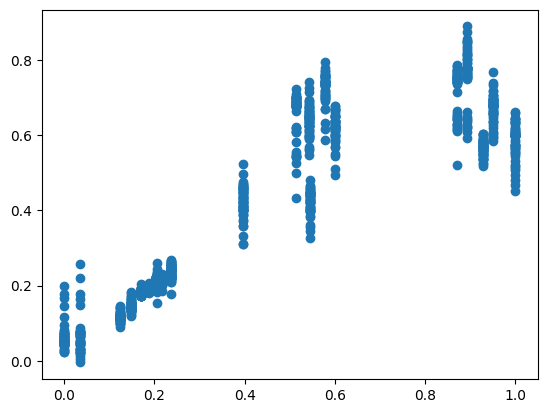

In [33]:
main()

In [34]:
# seems like C can't be too small, epsilon preferably 0.1 to 0.001, 
# https://www.ibm.com/think/topics/hyperparameter-tuning
# lower C allows for higher tolerance and a smoother boundary
# reps is the number repetition of the circuit, not sure if it will lead 

In [35]:
# Through two runs, I observe the following reps, C, and epsilon values that will provide a strong correlation (>0.70)
# reps = 1 or 2, preferably 1;  C = 1, 10, or 100; epsilon = 0.01 or 0.001 (makes sense as smaller step size lead to better result)